In [3]:
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import accuracy_score
from keras import backend
import glob
import random
import CNN_Module as cnn_module
import models
import glue_code

Using TensorFlow backend.


In [64]:
augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train, params_test = cnn_module.get_params_train_test(80,augment_valid,augment_valid)
params_test['batch_size']=24
params_train['batch_size']=32
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [20]:
def get_im_paths_labels(control_path,sus_path,proportion_train):
    #prep cells for feeding into CNN
    control_cells = np.array(cnn_module.findallcells_indir(control_path))
    sus_cells     = np.array(cnn_module.findallcells_indir(sus_path))
    
    #label cells, and split cells into test and train, making sure to have equal proportion of sus and ctrl in both
    control_cells_label = cnn_module.create_label_dict(control_cells,0)
    sus_cells_label  = cnn_module.create_label_dict(sus_cells,1)
    
    train_ctrl, test_ctrl = cnn_module.split_train_test(control_cells_label,proportion_train)
    train_sus, test_sus = cnn_module.split_train_test(sus_cells_label,proportion_train)
    
    
    
    train_labels = train_ctrl+train_sus#+train_sus
    test_labels = test_ctrl+test_sus
    
    random.shuffle(train_labels)
    random.shuffle(test_labels)
    
    video_path = '/cropped_video80'
    sample_gap = 10
    im_paths_train, im_labels_train, im_paths_test, im_labels_test = cnn_module.get_labels_images(train_labels,test_labels,video_path,sample_gap)
    return im_paths_train, im_labels_train, im_paths_test, im_labels_test

In [31]:
1-susweight

0.4

In [92]:
result = []
model = models.get_luke_model(80)
for susweight in [0.5,0.525,0.55,0.575,0.6,0.625,0.65,0.675,0.7,0.725,0.75,0.775,0.80,0.825,0.85,0.875,0.9,0.925,0.95,0.975,0.95,0.99,0.999]:
    this_result = []
    print(susweight)
    for repeat in range(20):
    
        im_paths_train, im_labels_train, im_paths_test, im_labels_test = get_im_paths_labels('/home/ubuntu/data/control/','/home/ubuntu/data/susceptible/',0.9)
        
        
        random.shuffle(im_paths_train)
        random.shuffle(im_paths_test)

        training_generator = DataGenerator.DataGenerator(im_paths_train, im_labels_train, **params_train)
        prediction_generator = DataGenerator.DataGenerator(im_paths_test, im_labels_test, **params_test)
        
        sample_gap=10
        epochs=20
        stepsperepoch=100
        video_path = '/cropped_video80'
        validate_steps = len(im_paths_test)//24.
        class_weights = {0: 1-susweight,1: susweight}
        

        model.fit_generator(generator=training_generator,epochs = epochs,steps_per_epoch=stepsperepoch,verbose=0,class_weight=class_weights)
    
        preds = model.predict_generator(generator=prediction_generator,workers=1,steps = validate_steps, use_multiprocessing=False)
                
        filenames_preds = dict(zip(prediction_generator.filenames,preds))
        label_prediction=[]
        for key in filenames_preds.keys():
            image_preds = []
            correct_label = im_labels_test[key]    
            prediction = np.argmax(filenames_preds[key])
            label_prediction.append([correct_label,prediction])
            
        label_prediction = np.array(label_prediction)
        confmat = confusion_matrix(label_prediction[:,0],label_prediction[:,1])
        overall_accuracy = (confmat[0][0]+confmat[1][1])/sum(sum(confmat))
        control_accuracy = confmat[0][0]/(confmat[0][0]+confmat[0][1])
        sus_accuracy = confmat[1][1]/(confmat[1][1]+confmat[1][0])
        
        this_result.append([susweight,overall_accuracy,control_accuracy,sus_accuracy])
        print(repeat,end=',')
        reset_weights(model)
    print(np.average(this_result,axis=0))
    result.append(this_result)
    pickle.dump(result,open('/home/ubuntu/data/code/2dCNN/label_weights_result_cache.p','wb'))

0.5
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,[0.5        0.81710526 0.853125   0.75535714]
0.525
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,[0.525      0.79337719 0.86652778 0.66797619]
0.55
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,[0.55       0.79679825 0.85180556 0.7025    ]
0.575
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,[0.575      0.79429825 0.87239583 0.66041667]
0.6
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,[0.6        0.77247807 0.83302083 0.66869048]
0.625
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,[0.625      0.7864693  0.8459375  0.68452381]
0.65
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,[0.65       0.77923246 0.83427083 0.68488095]
0.675
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,[0.675      0.75839912 0.81190972 0.66666667]
0.7
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,[0.7        0.76464912 0.804375   0.69654762]
0.725
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,[0.725      0.76736842 0.80715278 

In [88]:
result=pickle.load(open('/home/ubuntu/data/code/2dCNN/label_weights_32_batch_size.p','rb'))
result=np.array(result)

In [90]:
result=np.delete(result,20,0)

In [91]:
result.shape

(22, 20, 4)

In [121]:
result=np.array(result)
result_av = np.average(result,axis=1)
stds = np.std(result,axis=1)
ratios = result_av[:,0]/(1-result_av[:,0])

In [193]:
ratios

array([  1.        ,   1.10526316,   1.22222222,   1.35294118,
         1.5       ,   1.66666667,   1.85714286,   2.07692308,
         2.33333333,   2.63636364,   3.        ,   3.44444444,
         4.        ,   4.71428571,   5.66666667,   7.        ,
         9.        ,  12.33333333,  19.        ,  39.        ,
        99.        , 999.        ])

In [192]:
mvav_ctrl

[[1.0, 0.7227936246867168],
 [1.1052631578947374, 0.7236107847744361],
 [1.2222222222222225, 0.7283859388053466],
 [1.3529411764705874, 0.7289295243316624],
 [1.4999999999999991, 0.7321025741436926],
 [1.6666666666666667, 0.738327498433584],
 [1.8571428571428583, 0.7397313074352547],
 [2.0769230769230793, 0.7431861424394319],
 [2.3333333333333304, 0.7491352600250627],
 [2.636363636363633, 0.7508320671470343],
 [3.0, 0.7556180686090225],
 [3.444444444444449, 0.7615847561612364],
 [4.0000000000000036, 0.7617318295739349],
 [4.714285714285702, 0.7627698673767754],
 [5.666666666666661, 0.7699901837928154],
 [7.0, 0.7629611137218044],
 [9.000000000000002, 0.7500814144736843],
 [12.3333333333334, 0.7322804615705931],
 [18.99999999999985, 0.7246181632466583],
 [38.999999999999964, 0.7041646999443051],
 [98.9999999999988, 0.6870187382518796],
 [998.9999999999991, 0.6661008380325815]]

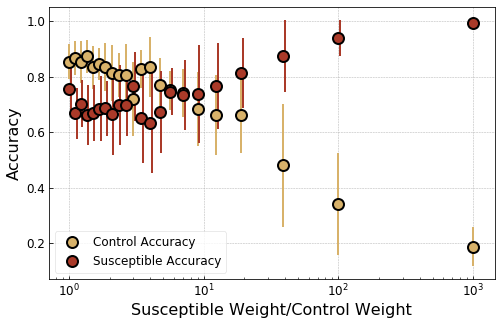

In [210]:
plt.style.use('bmh')
plt.rcParams.update({"figure.figsize" : (8, 5),
                     "axes.facecolor" : "white",
                     "axes.edgecolor":  "black"})

plt.xticks([1,5,10],fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)


ctrl_col = '#D8B26A'
sus_col = '#AA3A29'


plt.plot(ratios,result_av[:,2],'o',markersize=11,mew=2,mec='black',color=ctrl_col,linewidth=0,label='Control Accuracy')
plt.errorbar(ratios,result_av[:,2],yerr=stds[:,2],color=ctrl_col,elinewidth=2,lw=0)

plt.plot(ratios,result_av[:,3],'o',markersize=11,mew=2,mec='black',color=sus_col,linewidth=0,label='Susceptible Accuracy')
plt.errorbar(ratios+(0.03*ratios),result_av[:,3],yerr=stds[:,3],color=sus_col,elinewidth=2,lw=0)
plt.xscale('log')
plt.xlabel('Susceptible Weight/Control Weight',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.legend(loc=3,frameon=True,fontsize=12)
plt.xticks([1, 10, 100,1000])
#plt.ylim(0.4,1.0)
#plt.xlim(0.8,30)
plt.savefig('/home/ubuntu/data/figures/tuning_accuracies.png',dpi=500)

In [150]:
ratios+0.1*ratios

array([   1.1       ,    1.21578947,    1.34444444,    1.48823529,
          1.65      ,    1.83333333,    2.04285714,    2.28461538,
          2.56666667,    2.9       ,    3.3       ,    3.78888889,
          4.4       ,    5.18571429,    6.23333333,    7.7       ,
          9.9       ,   13.56666667,   20.9       ,   42.9       ,
        108.9       , 1098.9       ])

In [133]:
np.ma.masked_where(np.array(result)[:,:,3] <= 0.5, np.array(result))

IndexError: Inconsistent shape between the condition and the input (got (23, 20) and (23, 20, 4))

In [134]:
np.array(result).flatten()

array([0.5       , 0.81622807, 0.79166667, ..., 0.4872807 , 0.19027778,
       0.99642857])

In [1]:
result

NameError: name 'result' is not defined